In [1]:
# import plotly.io as pio
# pio.orca.status

In [2]:
# %%time
# import plotly.io as pio
# from IPython.display import SVG, display
# img_bytes = pio.to_image(fig, format="svg")
# display(SVG(img_bytes))

In [3]:
# %%time
# import plotly.io as pio
# from IPython.display import Image, display
# img_bytes = pio.to_image(fig, format="png")
# display(Image(img_bytes))

In [4]:
#! pip install pmdarima

# OUTLINE:
GETTING DATA  
EDA (TREND, SEASONALITY) -> the Dickey–Fuller test-> STATIONARITY  
DATA ENGINEERING, PREPROCESING  
MODELING (ARIMA)  
FORECAST, ERRORS

In [5]:
%matplotlib inline

In [2]:
# import libraries
# general:
import pickle
import numpy as np
import pandas as pd
import itertools
from math import ceil
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# models:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima.arima import auto_arima

# metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


TIME SERIES:

univariate TS is a sequence of measurments of the SAME variable collected over time

data in TS not necessarly independent and not necessarly identically distributed

the ordering matters

***
***
# PART_1
***
***

GETTING DATA FROM IMF

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/USA/WEOWORLD

IMF DATA MAPPER:  
https://www.imf.org/external/datamapper/datasets

DATASETS:  
https://www.imf.org/external/pubs/ft/weo/2019/01/weodata/index.aspx


In [15]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/world_data.xls', sep= '\t', index_col= 0, header= None)

In [16]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'WORLD_GROWTH', 'WORLD_GDP']

# chage data type from string --> float
data.WORLD_GDP= data.WORLD_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [17]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

In [18]:
# create separate series
world_growth_train= data_train.WORLD_GROWTH
world_gdp_train= data_train.WORLD_GDP

In [19]:
# save every series as a pickle fle
with open ('world_growth_train.pickle', 'wb') as file:
    pickle.dump(world_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('world_gdp_train.pickle', 'wb') as file:
    pickle.dump(world_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [20]:
# def get_clean (file_name):
#     data= pd.read_csv(file_name, sep= '\t', index_col= 0, header= None)

REPEAT FOR US

In [21]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/us_data.xls', sep= '\t', index_col= 0, header= None)

In [22]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'US_GROWTH', 'US_GDP']

# chage data type from string --> float
data.US_GDP= data.US_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [24]:
# split data on actual and predicted
dataUS_train= data.iloc[:-6, :]
dataUS_test= data.iloc[-6:, :]

# create separate series
us_growth_train= dataUS_train.US_GROWTH
us_gdp_train= dataUS_train.US_GDP

# save every series as a pickle fle
with open ('us_growth_train.pickle', 'wb') as file:
    pickle.dump(us_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('us_gdp_train.pickle', 'wb') as file:
    pickle.dump(us_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [25]:
# create forecast variables
world_growth_forecast= data_test.WORLD_GROWTH
world_gdp_forecast= data_test.WORLD_GDP

us_growth_forecast= dataUS_test.US_GROWTH
us_gdp_forecast= dataUS_test.US_GDP

In [26]:
world_gdp_forecast, world_growth_forecast

(YEAR
 2019-01-01     87265.226
 2020-01-01     92310.269
 2021-01-01     97455.030
 2022-01-01    102843.476
 2023-01-01    108527.396
 2024-01-01    114577.260
 Name: WORLD_GDP, dtype: float64, YEAR
 2019-01-01    2.722
 2020-01-01    2.890
 2021-01-01    2.882
 2022-01-01    2.843
 2023-01-01    2.852
 2024-01-01    2.850
 Name: WORLD_GROWTH, dtype: float64)

In [30]:
us_gdp_forecast, us_growth_forecast

(YEAR
 2019-01-01    21344.667
 2020-01-01    22198.116
 2021-01-01    23059.653
 2022-01-01    23922.822
 2023-01-01    24812.956
 2024-01-01    25728.734
 Name: US_GDP, dtype: float64, YEAR
 2019-01-01    2.331
 2020-01-01    1.871
 2021-01-01    1.766
 2022-01-01    1.640
 2023-01-01    1.615
 2024-01-01    1.565
 Name: US_GROWTH, dtype: float64)

OVERALL IMAGES:
GROWTH
GDP

In [31]:
# create a graph using plotly library

layout= go.Layout(yaxis={"title": "annual growth, %"}, xaxis= {'title': 'year'})


fig= go.Figure(layout=layout)

fig.add_trace(go.Scatter(
    x= world_growth_train.index,
    y= world_growth_train,
    name= 'world_growth',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_growth_train.index,
    y= us_growth_train, 
    name= 'us_growth',
    line_color= 'red',
    opacity= .8)
             )
layout= go.Layout(showlegend= True)
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GROWTH') #xaxis_rangeslider_visible=True
fig.write_image('images/fig1a.png')

fig.show()
# img_bytes = pio.to_image(fig, format="svg")
# display(Image(img_bytes))

In [32]:
# create a graph for GDP using plotly library 
layout= go.Layout(yaxis={"title": "billions, US dollars"}, xaxis= {'title': 'year'})

fig= go.Figure(layout= layout)

fig.add_trace(go.Scatter(
    x= world_gdp_train.index,
    y= world_gdp_train,
    name= 'world_gdp',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_gdp_train.index,
    y= us_gdp_train, 
    name= 'us_gdp',
    line_color= 'red',
    opacity= .8)
             )
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GDP') # xaxis_rangeslider_visible=True

fig.write_image('images/fig2a.png')

fig.show()

In [33]:
# WORLD ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= world_growth_train.index,
               y= world_growth_train,
               name="yaxis data"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= world_gdp_train.index,
               y= world_gdp_train,
               name="yaxis2 data"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="WORLD GROWTH w/ WORLD GDP"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)
fig.write_image('images/fig3a.png')

fig.show()

In [64]:
# USA ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= us_growth_train.index,
               y= us_growth_train,
               name="USA GROWTH"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= us_gdp_train.index,
               y= us_gdp_train,
               name="USA GDP"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="USA GROWTH w/ USA GDP"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)
fig.write_image('images/fig4a.png')

fig.show()

In [63]:
# # GROUPING
# # Use pandas grouper to group values using three-annual frequency
# groups = us_gdp_train.groupby(pd.Grouper(freq ='4A', closed= 'left'))
# #Create a new DataFrame and store yearly values in columns 
# temp = pd.DataFrame()

# # Plot overlapping yearly groups 
# plt.figure(figsize = (22,15))
# for period, group in groups:
#     group.plot(subplots=True)
# #     temp[period] = group.values.ravel()

# # # Plot the yearly groups as subplots
# # temp.plot(figsize = (22,15), subplots=True, legend=True)
# # plt.show()

***
***
# PART_2
***
***

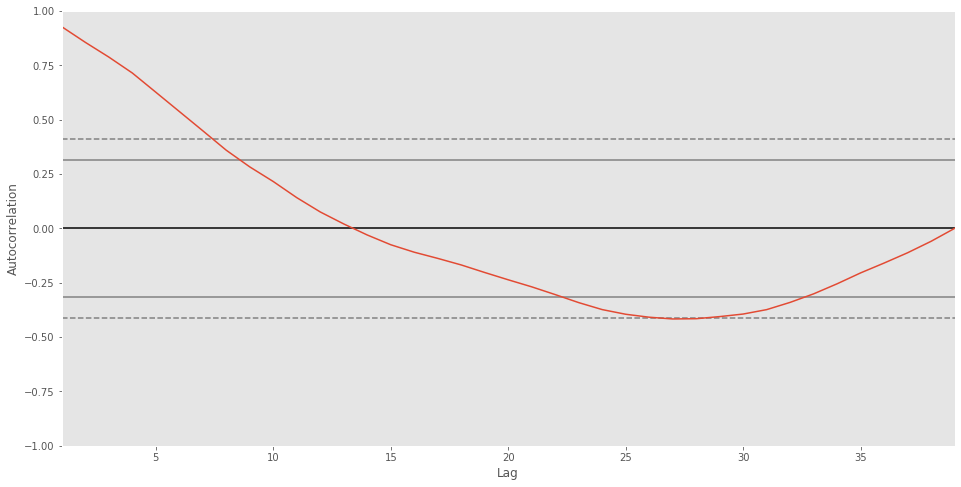

In [15]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(world_gdp_train);

In [69]:
# calculate and plot rolling stats:
#for USA gdp and growth
ROL_M_US_GDP= us_gdp_train.rolling(window = 4, center = False).mean()
ROL_STD_US_GDP= us_gdp_train.rolling(window = 4, center = False).std()

ROL_M_US_GROWTH= us_growth_train.rolling(window = 4, center = False).mean()
ROL_STD_US_GROWTH= us_growth_train.rolling(window = 4, center = False).std()

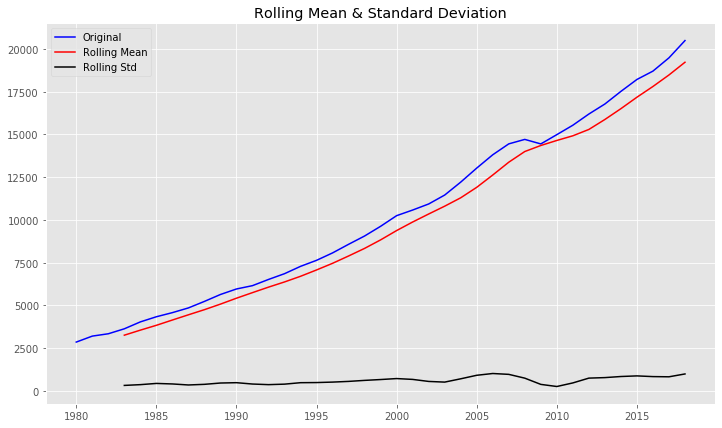

In [70]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(us_gdp_train, color='blue',label='Original')
mean = plt.plot(ROL_M_US_GDP, color='red', label='Rolling Mean')
std = plt.plot(ROL_STD_US_GDP, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

RED line represents mean which is not constant therefore there is a trend. Though the variation in standard deviation is small, mean is clearly increasing with time and thus, this is not a stationary series.

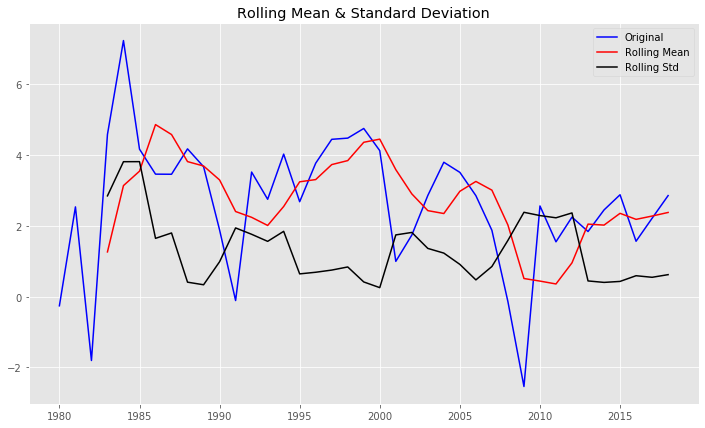

In [73]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(us_growth_train, color='blue',label='Original')
mean = plt.plot(ROL_M_US_GROWTH, color='red', label='Rolling Mean')
std = plt.plot(ROL_STD_US_GROWTH, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [87]:
# USA GROWTH ROLLING STATS
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= us_growth_train.index,
               y= us_growth_train,
               name="USA GROWTH"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= ROL_M_US_GROWTH.index,
               y= ROL_M_US_GROWTH,
               name="Rolling MEAN USA GROWTH"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( x= ROL_STD_US_GROWTH.index,
               y= ROL_STD_US_GROWTH,
               name="Rolling STD USA GROWTH"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rolling STATS for USA GROWTH"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="%", secondary_y=True)
fig.write_image('images/fig5.png')

fig.show()

You can use the Dicky-Fuller test to check the stationarity of the time series data.

The null hypothesis  Ho  assumes that the time series is dependent on time (that it is non-stationary). Since the Test Statistic is larger than the Critical Values, we cannot reject the null hypothesis and understand that the series is non-stationary

In [77]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

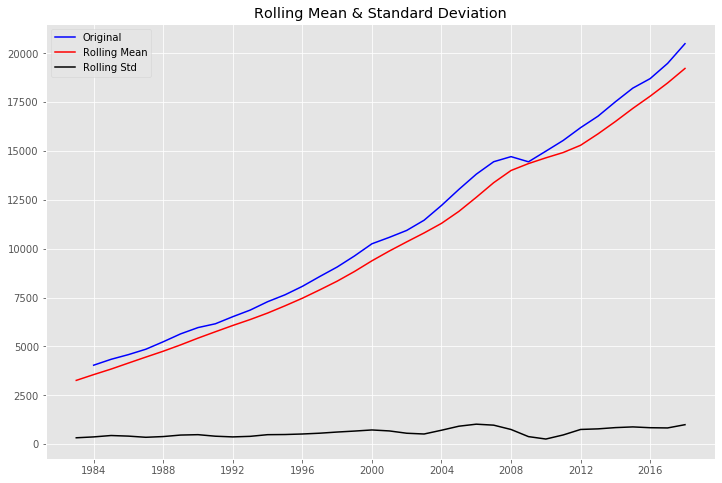

Results of Dickey-Fuller Test:
Test Statistic                  2.544136
p-value                         0.999063
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [86]:
test_stationarity(us_gdp_train, 4)

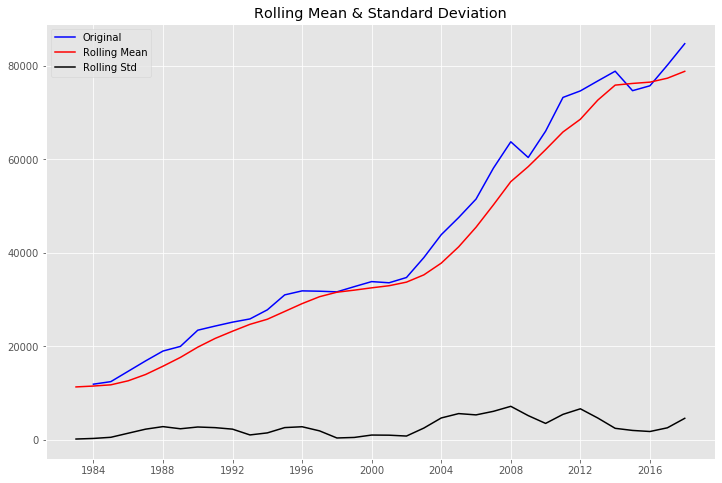

Results of Dickey-Fuller Test:
Test Statistic                  1.357629
p-value                         0.996913
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [81]:
test_stationarity(world_gdp_train, 4)

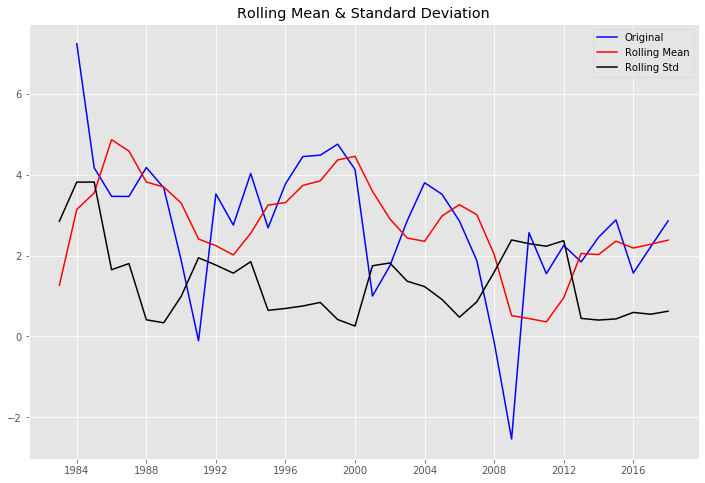

Results of Dickey-Fuller Test:
Test Statistic                 -4.434479
p-value                         0.000258
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [83]:
test_stationarity(us_growth_train, 4)

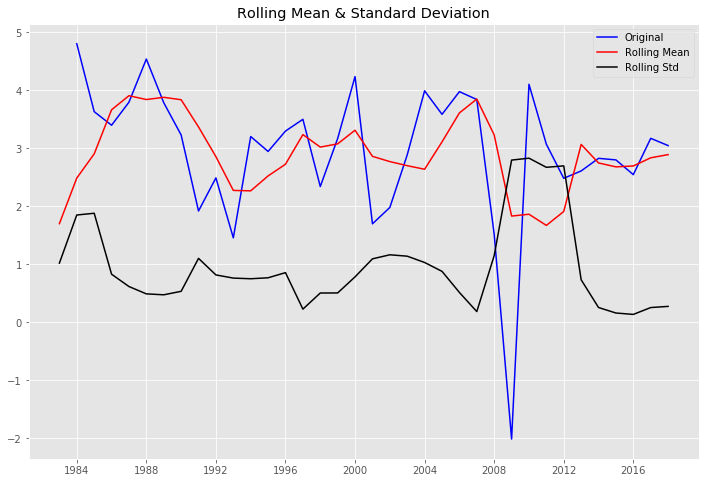

Results of Dickey-Fuller Test:
Test Statistic                 -4.584593
p-value                         0.000138
#Lags Used                      1.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [85]:
test_stationarity(world_growth_train, 4)

***
***
# PART_3
***
***

In [24]:
# log_transformation
# subtract rolling mean
# differecing
# pandas diff(periods= 1)
# decomposition
# decompostion= seasonal_decompose()
# trend= decomposition.trend
# seasonal= decomposition.seasonal
# residual= decomposition.resid

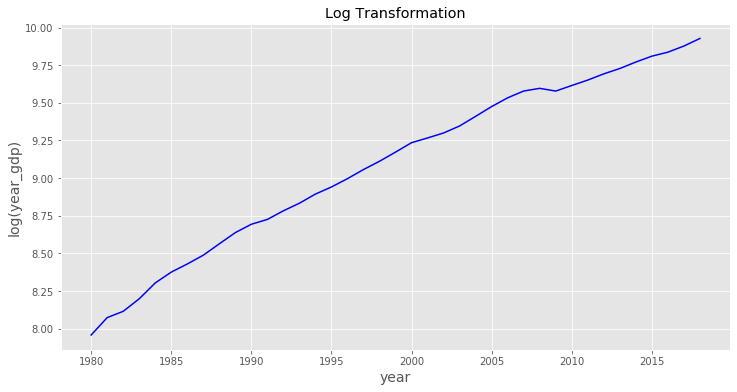

In [90]:
log_us_gdp = pd.Series(np.log(us_gdp_train))
fig = plt.figure(figsize=(12,6))
plt.plot(log_us_gdp, color="blue")
plt.xlabel("year", fontsize=14)
plt.ylabel("log(year_gdp)", fontsize=14)
plt.title('Log Transformation')
plt.show()

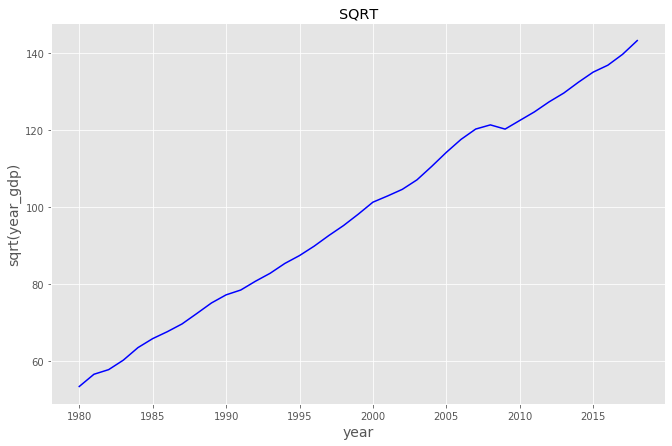

In [91]:
sqrt_us_gdp = pd.Series(np.sqrt(us_gdp_train))
fig = plt.figure(figsize=(11,7))
plt.plot(sqrt_us_gdp, color="blue")
plt.xlabel("year", fontsize=14)
plt.ylabel("sqrt(year_gdp)", fontsize=14)
plt.title('SQRT')
plt.show()

Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of an observation at a particular time instant with that at the previous instant (i.e. a co-called 1-period "lag"). 


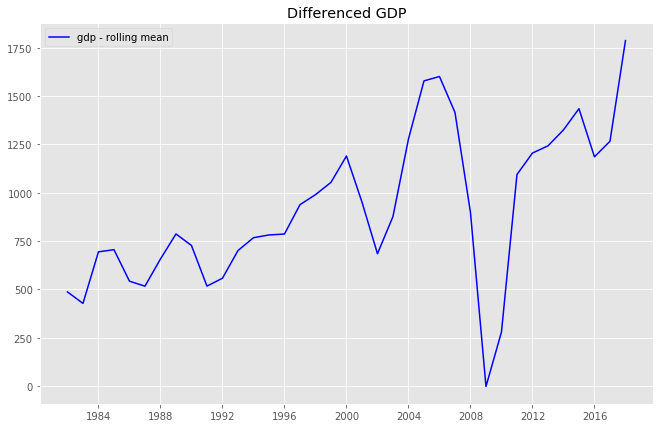

In [99]:
us_gdp_diff = us_gdp_train.diff(periods=2)
us_gdp_diff.head(10)

fig = plt.figure(figsize=(11,7))
plt.plot(us_gdp_diff, color='blue',label='gdp - rolling mean')
plt.legend(loc='best')
plt.title('Differenced GDP')
plt.show(block=False)

In [100]:
us_gdp_diff= us_gdp_diff.dropna()

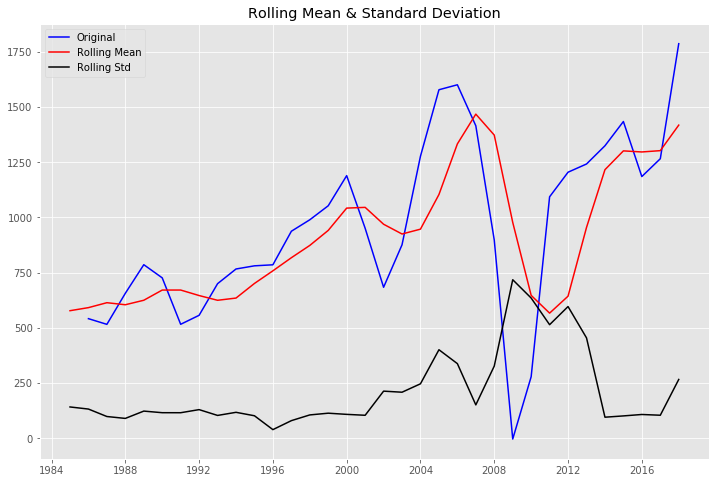

Results of Dickey-Fuller Test:
Test Statistic                 -0.830377
p-value                         0.810036
#Lags Used                      8.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [101]:
test_stationarity(us_gdp_diff, 4)

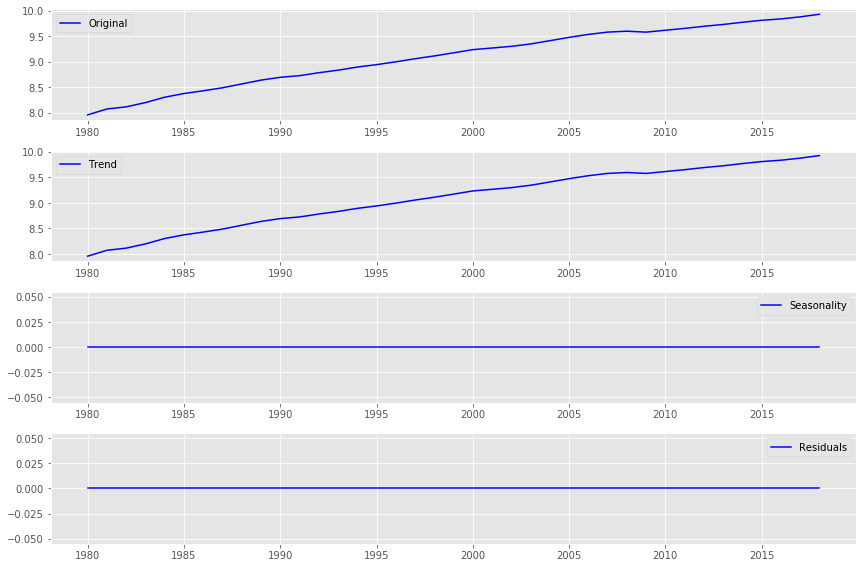

In [103]:
decomposition = seasonal_decompose(np.log(us_gdp_train))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(us_gdp_train), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

***
***
# PART_4
***
***

PART_4.1 SAMPLE AUTOCORRELATION FUNCTION (ACF)

A sample autocorrelation function (ACF)for a series gives correlations between the series $x_t$ and lagged values of the series for lags 1, 2, 3, and so on. The lagged values can be written as $x_{t-1}, x_{t-2}, x_{t-3}$, and so on. The ACF gives correlations between $x_t$ and $x_{t-1}$, $x_t$ and $x_{t-2}$, and so on.

The ACF can be used to identify possible structure of time series data.

In [25]:
#?np.arange

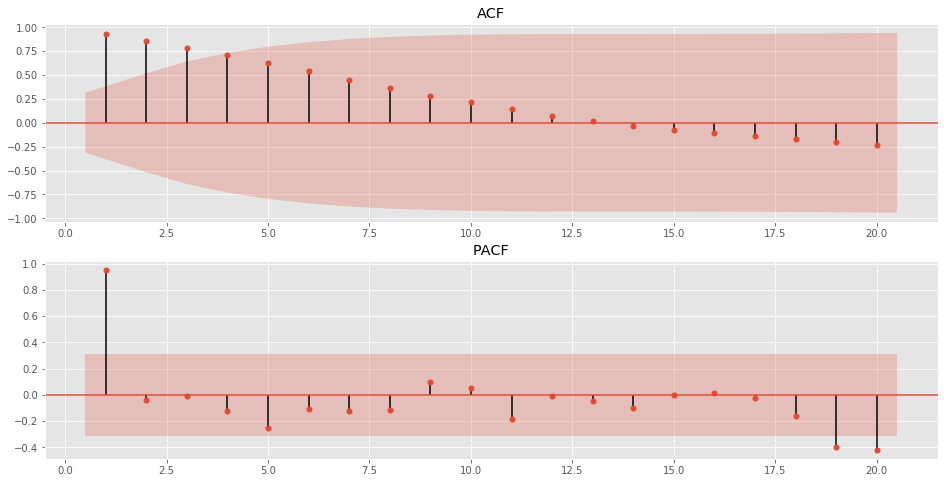

In [26]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_gdp_train, lags=20, title='ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_gdp_train, lags=20, title= 'PACF', zero= False, ax=ax2)

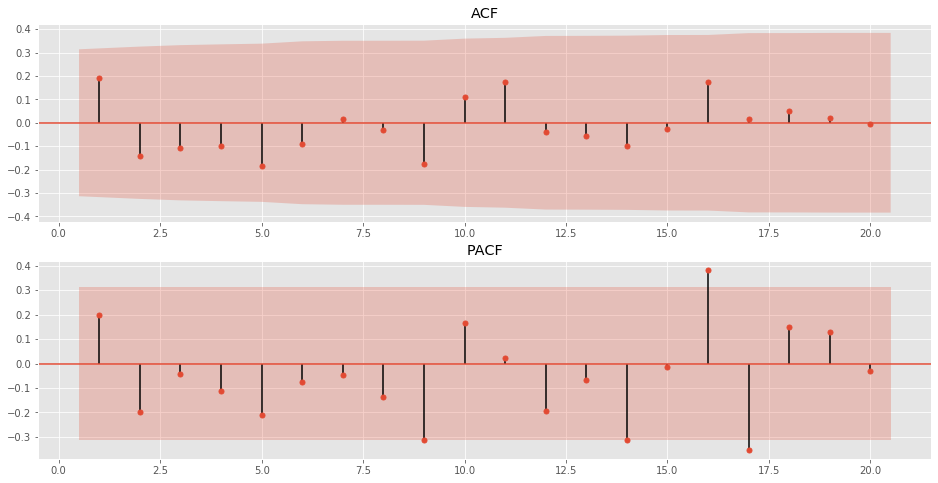

In [27]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_growth_train, lags=20, title= 'ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_growth_train, lags=20, title= 'PACF', zero= False, ax=ax2)

In [28]:
def explore_first_difference(Series, n):
    '''
    Input: pandas.Series, number of differnces
    Output: 
    '''
    diff= Series.diff(n)
    
    fig = plt.figure(figsize=(16,8))
    
    # plot difference
    ax1= fig.add_subplot(211)
    plt.plot(diff, ax= ax1)
    
    #plot the ACF
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_acf(diff, lags=18, ax=ax2)
    
    #plot the PACF
    ax3 = fig.add_subplot(213)
    fig = sm.graphics.tsa.plot_pacf(diff, lags=18, ax=ax3)

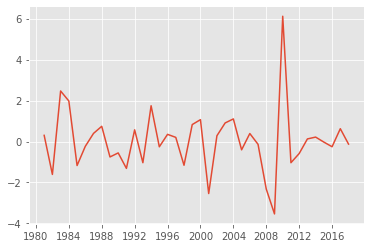

In [29]:
first_diff= world_growth_train.diff(1)
plt.plot(first_diff)

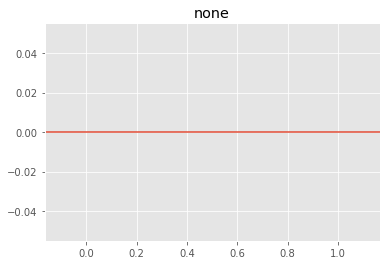

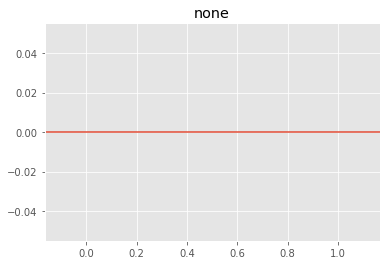

In [30]:
sm.graphics.tsa.plot_acf(first_diff, title='none')

In [31]:
#explore_first_difference(world_gdp_train, 1)

One of the simplest ARIMA type models is a model in which we use a linear model to predict the value at the present time using the value at the previous time. This is called __an AR(1) model__, standing for autoregressive model of order 1. The order of the model indicates how many previous times we use to predict the present time.

In [32]:
# create a function which outputs a dataframe with lags
def shift_n (Series, n):
    '''
    Input: pandas.Series, number of lags
    Ouput: dataFrame
    '''
    data= pd.DataFrame(Series)
    data['lag']= data.shift(n)
    return data

In [33]:
data= shift_n(world_gdp_train, 1)

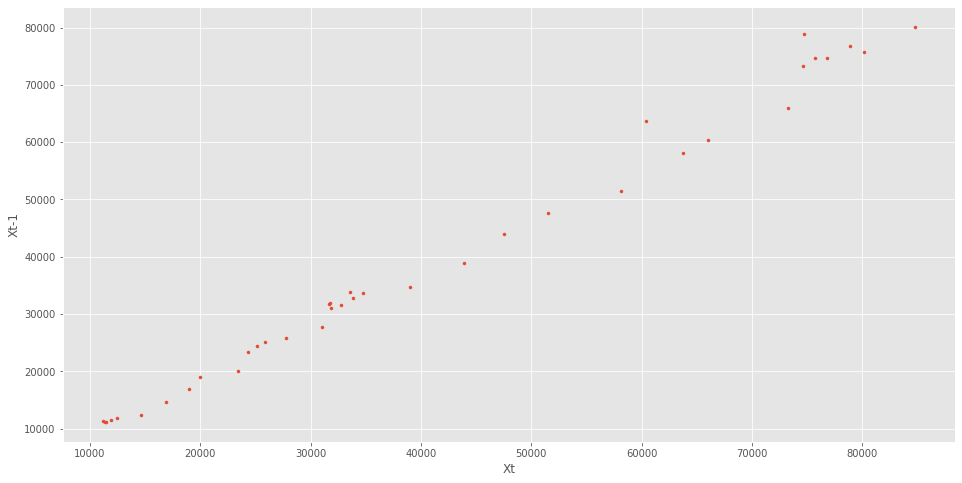

In [34]:
plt.figure(figsize= (16, 8))
plt.scatter(data.WORLD_GDP, data.lag, marker= '.')
plt.xlabel('Xt')
plt.ylabel('Xt-1')
plt.show()

the same with plotly

In [35]:
dat= go.Scatter(x= data.WORLD_GDP, y= data.lag,
                 mode= 'markers', marker=dict(size=list(range(10, 100, 10))*1000, color=[0, 1, 2, 3])
                 )

fig= go.Figure(data= dat)

fig.show()

the AR(1) model is written:
$x_t = \delta + \phi_1x_t-1 + \epsilon_t$

Assumptions:
- $\epsilon_t \stackrel{\text{iid}}{\sim} N(0, \sigma^2_t)$, meaning that the errors are independently distributed with a normal distribution that has mean 0 and constant variance;
- Properties of the errors $\epsilon_t$ are independent of $x$.

In [36]:
# create train/test split
train= data.WORLD_GDP.iloc[: ceil(.8*len(data))]
test= data.WORLD_GDP.iloc[len(train) : ]

In [37]:
# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

a lag value chose is 9
the coefs are:
 const          -198.082576
L1.WORLD_GDP      1.004984
L2.WORLD_GDP     -0.234515
L3.WORLD_GDP      0.554258
L4.WORLD_GDP      0.117126
L5.WORLD_GDP     -0.628361
L6.WORLD_GDP     -0.482215
L7.WORLD_GDP      0.783994
L8.WORLD_GDP     -0.106731
L9.WORLD_GDP      0.104666
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

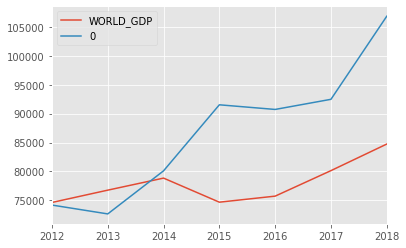

In [38]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

In [39]:
print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

r2 score: -13.661876624197705
RMSE: 12914.779663027884


GROWTH

a lag value chose is 9
the coefs are:
 const              9.610817
L1.WORLD_GROWTH   -0.042274
L2.WORLD_GROWTH   -0.245613
L3.WORLD_GROWTH   -0.361858
L4.WORLD_GROWTH   -0.463648
L5.WORLD_GROWTH   -0.495068
L6.WORLD_GROWTH    0.131543
L7.WORLD_GROWTH   -0.278283
L8.WORLD_GROWTH    0.159511
L9.WORLD_GROWTH   -0.646063
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

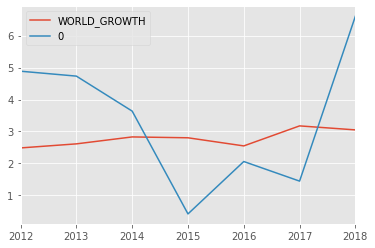

r2 score: -80.13538470438732
RMSE: 2.151425410397956


In [40]:
# create train/test split
number= len(world_growth_train)
train= world_growth_train.iloc[: ceil(.8*number)]
test= world_growth_train.iloc[len(train):]

# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

# RESIDUAL ANALYSIS#

In [41]:
# mod= ARIMA(data_train.WORLD_GROWTH, (1, 1, 0))
# res= mod.fit()

In [42]:
# res.summary()

In [43]:
# data_train['predict'] = res.predict(start= 32, end= 39, dynamic= False)  
# data_train[['WORLD_GROWTH', 'predict']].plot(figsize=(16, 12)) 

In [44]:
#world_growth_train

***
# MODEL SELECTION
***
***

In [45]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [46]:
# Run a grid with pdq parameters calculated above and get the best AIC value

def best_param(Series):
    aic= []
    bic= []
    for comb in pdq:
        try:
            model= sm.tsa.statespace.SARIMAX(Series,
                                            order= comb,
                                            enforce_stationarity= False,
                                            enforce_invertibility= False)

            output= model.fit()
            aic.append([comb, output.aic])
            bic.append([comb, output.bic])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
            print('ARIMA {} : BIC Calculated ={}'.format(comb, output.bic))
        except:
            continue
   
    # Find the parameters with minimal AIC value.

    aicFrame = pd.DataFrame(aic, columns=['COMBINATION', 'AIC'])
    bicFrame = pd.DataFrame(bic, columns=['COMBINATION', 'BIC'])
    AIC= aicFrame.loc[aicFrame['AIC'].idxmin()]
    BIC= bicFrame.loc[bicFrame['BIC'].idxmin()]
    return AIC, BIC

In [47]:
best_param(us_gdp_train)

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165
ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 0) : BIC Calculated =521.9969012720277


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (1, 0, 1) : AIC Calculated =497.2968052520717
ARIMA (1, 0, 1) : BIC Calculated =502.12955899000434
ARIMA (1, 0, 2) : AIC Calculated =485.6867789737026
ARIMA (1, 0, 2) : BIC Calculated =492.020854727527


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 1, 0) : AIC Calculated =505.3900634769632
ARIMA (1, 1, 0) : BIC Calculated =508.61189930225163
ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905
ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1, 2, 2) : BIC Calculated =469.95873885105186


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 0, 0) : AIC Calculated =497.429455616674
ARIMA (2, 0, 0) : BIC Calculated =502.2622093546066
ARIMA (2, 0, 1) : AIC Calculated =498.28527292835906
ARIMA (2, 0, 1) : BIC Calculated =504.72894457893597
ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307
ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617
ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116
ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335


(COMBINATION    (0, 2, 2)
 AIC              462.141
 Name: 8, dtype: object, COMBINATION    (0, 2, 2)
 BIC               466.72
 Name: 8, dtype: object)

# GRID SEARCH ???

In [48]:
# Perform grid search for the ARIMA model.
stepwise_model = auto_arima(us_gdp_train, start_p=0, start_q=0, start_d= 0, max_p=5, max_q=5, seasonal=False, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 2, 0); AIC=505.503, BIC=508.725, Fit time=0.009 seconds
Fit ARIMA: order=(1, 2, 0); AIC=507.012, BIC=511.845, Fit time=0.060 seconds
Fit ARIMA: order=(0, 2, 1); AIC=503.215, BIC=508.048, Fit time=0.050 seconds
Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 2); AIC=498.281, BIC=504.725, Fit time=0.092 seconds
Fit ARIMA: order=(1, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 3); AIC=499.947, BIC=508.001, Fit time=0.089 seconds
Total fit time: 0.361 seconds
498.28095011312894


In [49]:
# plug the optimal parameter values into a new SARIMAX model.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(0, 2, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model and print results

output = ARIMA_MODEL.fit()

print(output.summary())


                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -228.070
Date:                Tue, 30 Jul 2019   AIC                            462.141
Time:                        16:28:04   BIC                            466.720
Sample:                    01-01-1980   HQIC                           463.702
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3821      0.125     -3.048      0.002      -0.628      -0.136
ma.L2         -0.3664      0.197     -1.858      0.063      -0.753       0.020
sigma2      3.896e+04   9139.389      4.263      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



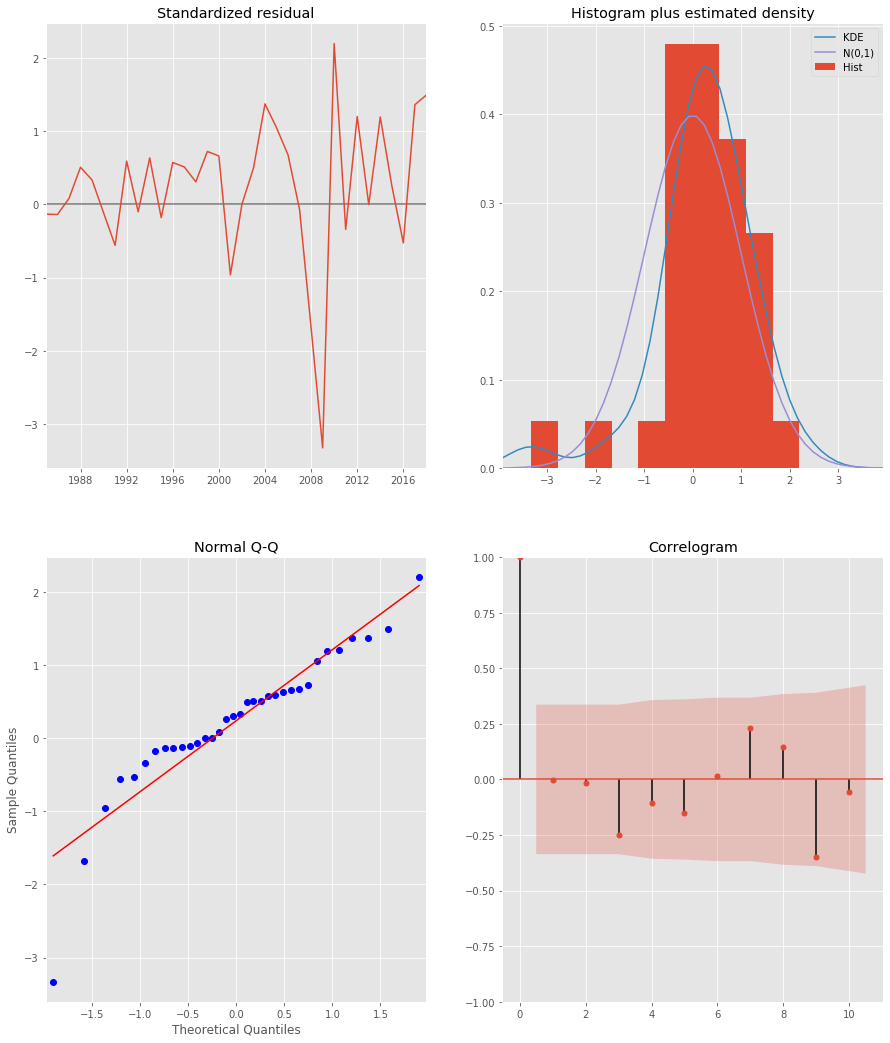

In [50]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [51]:
residuals= output.resid
res_stand= (residuals - np.mean(residuals))/np.std(residuals)

In [52]:
# fig = ff.create_distplot(hist_data= [res_stand], group_labels= ['resid'], bin_size= .5)
# fig.show()

NameError: name 'ff' is not defined

In [ ]:
# Get predictions starting from 01-01-2011 and calculate confidence intervals.

pred = output.get_prediction(start='2011-01-01', dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = us_gdp_train['2001':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range bfor confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')
plt.legend()

plt.show()

In [ ]:
# Get the Real and predicted values
GDP_forecasted = pred.predicted_mean
GDP_truth= us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# DYNAMIC

In [ ]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = us_gdp_train['2001':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2001-01-01'), GDP_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
GDP_forecasted = pred_dynamic.predicted_mean
GDP_truth = us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Get forecast 10 steps ahead in future
prediction = output.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# Plot future predictions with confidence intervals

ax = us_gdp_train.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

# PREDICTIONS

In [56]:
def analyse_series (Series, p, d, q, year):
    '''
    Input: Time Series, parametrs, starting year
    Output:
    '''
    # plug the optimal parameter values into a new SARIMAX model.
    model= sm.tsa.statespace.SARIMAX(Series,
                                order=(p, d, q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    # fit the model and print results

    output = model.fit()

    print(output.summary())
    
    # Use plot_diagnostics with results calculated above.
    output.plot_diagnostics(figsize=(18, 18))
    plt.show()
    
    # Get predictions starting from 01-01-year and calculate confidence intervals.

    prediction = output.get_prediction(start='{}-01-01'.format(year), dynamic=False)
    int_ = prediction.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 16, 8

    #Plot observed values
    ax = Series['{}'.format(year):].plot(label='observed')

    #Plot predicted values
    prediction.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.5)

    #Plot the range for confidence intervals
    ax.fill_between(int_.index,
                int_.iloc[:, 0],
                int_.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
    ax.set_xlabel('date')
    ax.set_ylabel('prediction')
    plt.legend()

    plt.show()
    
    # Extract the predicted and true values of our time series
    forecast= prediction.predicted_mean
    true= Series['{}-01-01'.format(year):]

    # Compute the mean squared error and root mean squared error
    mse = ((forecast - true) ** 2).mean()
    print('The Mean Squared Error is: {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error is: {}'.format(round(np.sqrt(mse), 2)))
    resid= output.resid
    return resid

# PREDICT US_GDP

In [57]:
best_param(us_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249
ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165
ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093
ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1, 2, 2) : BIC Calculated =469.95873885105186
ARIMA (2, 0, 0) : AIC Calculated =497.429455616674
ARIMA (2, 0, 0) : BIC Calculated =502.2622093546066
ARIMA (2, 0, 1) : AIC Calculated =498.28527292835906
ARIMA (2, 0, 1) : BIC Calculated =504.72894457893597


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307
ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617
ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116
ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335


(COMBINATION    (0, 2, 2)
 AIC              462.141
 Name: 8, dtype: object, COMBINATION    (0, 2, 2)
 BIC               466.72
 Name: 8, dtype: object)

                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -228.070
Date:                Tue, 30 Jul 2019   AIC                            462.141
Time:                        16:33:28   BIC                            466.720
Sample:                    01-01-1980   HQIC                           463.702
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3821      0.125     -3.048      0.002      -0.628      -0.136
ma.L2         -0.3664      0.197     -1.858      0.063      -0.753       0.020
sigma2      3.896e+04   9139.389      4.263      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



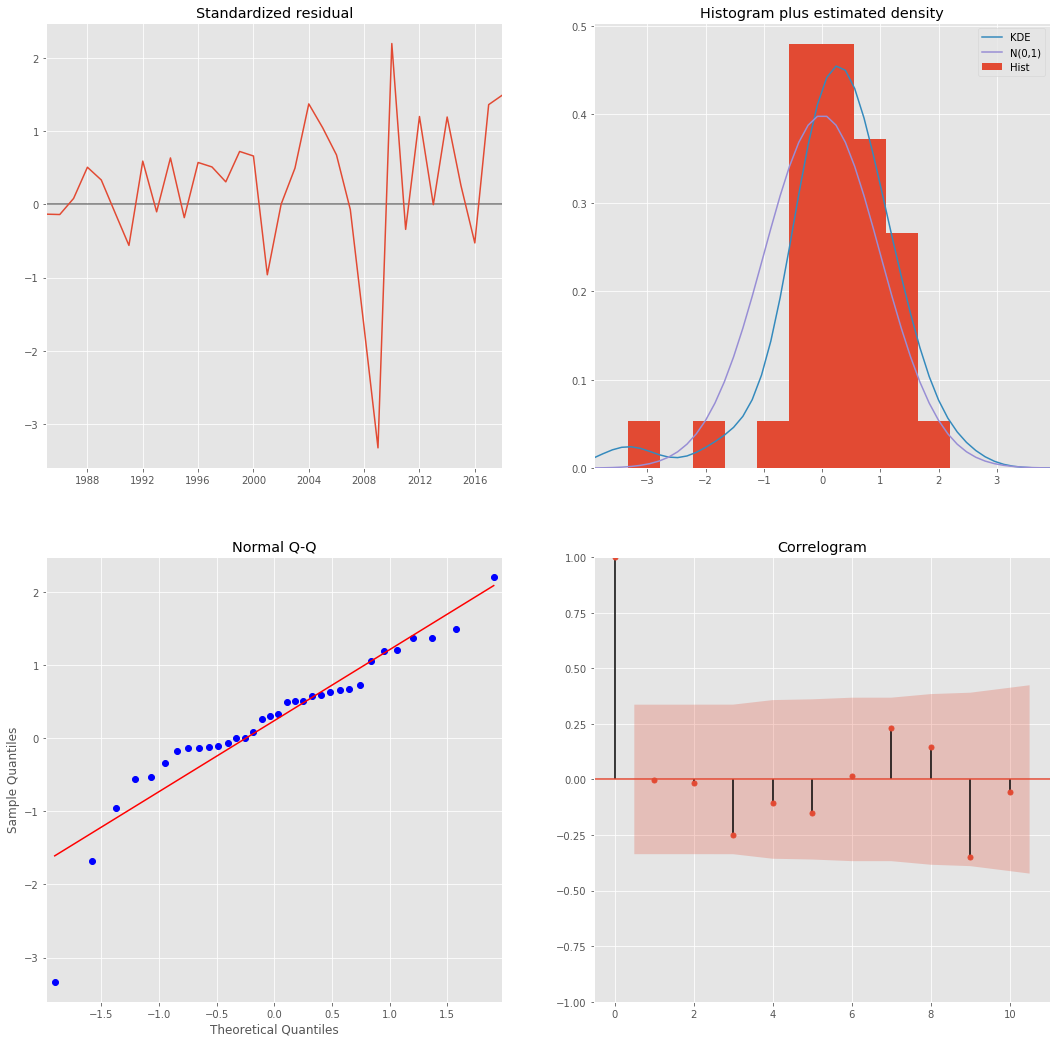

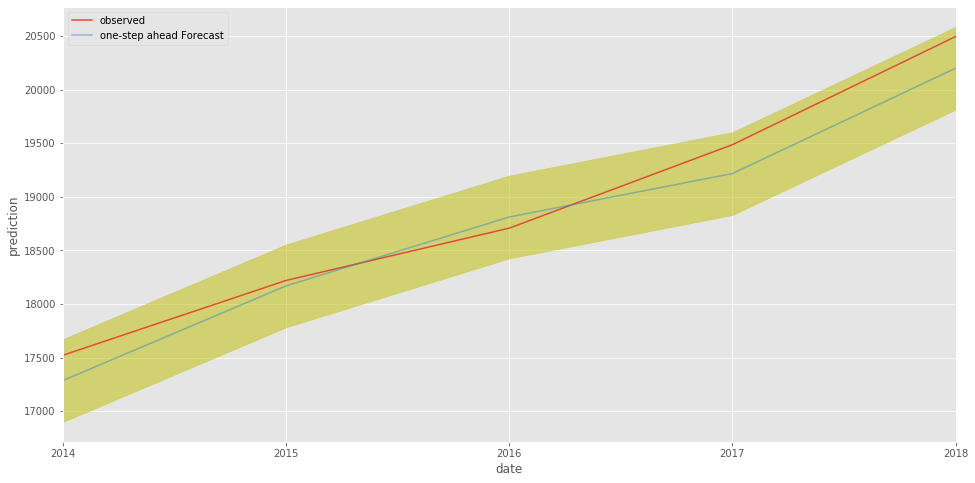

The Mean Squared Error is: 45689.42
The Root Mean Squared Error is: 213.75


YEAR
1980-01-01    2857.325000
1981-01-01   -1555.183333
1982-01-01    -226.501433
1983-01-01     138.360172
1984-01-01     136.943882
1985-01-01     -27.645451
1986-01-01     -28.331177
1987-01-01      16.355845
1988-01-01     101.550839
1989-01-01      66.351593
1990-01-01     -23.047156
1991-01-01    -111.220638
1992-01-01     117.093382
1993-01-01     -20.180165
1994-01-01     125.492856
1995-01-01     -35.872210
1996-01-01     113.081290
1997-01-01     101.032739
1998-01-01      60.775588
1999-01-01     142.785489
2000-01-01     130.550708
2001-01-01    -190.017738
2002-01-01       0.384631
2003-01-01      97.712971
2004-01-01     271.149303
2005-01-01     206.827643
2006-01-01     133.446855
2007-01-01     -13.930515
2008-01-01    -332.755578
2009-01-01    -657.109292
2010-01-01     434.005343
2011-01-01     -67.484550
2012-01-01     237.126952
2013-01-01      -0.785947
2014-01-01     235.730830
2015-01-01      50.418545
2016-01-01    -104.063424
2017-01-01     269.106376
2018-01

In [58]:
analyse_series(us_gdp_train, 0, 2, 2, 2014)

In [59]:
t1

NameError: name 't1' is not defined

# PREDICT US_GROWTH

In [ ]:
best_param(us_growth_train)

In [ ]:
analyse_series(us_growth_train, 0, 1, 2, 2014)

In [ ]:
t2= output.resid

In [ ]:
t2

# PREDICT WORLD_GDP

In [ ]:
best_param(world_gdp_train)

In [ ]:
analyse_series(world_gdp_train, 0, 2, 2, 2014)

In [ ]:
t3= output.resid

# PREDICT WORLD_GROWTH

In [ ]:
best_param(world_growth_train)

In [ ]:
analyse_series(world_growth_train, 0, 1, 2, 2014)

In [ ]:
t4= output.resid

***
***

In [ ]:
residuals= [t1, t2, t3, t4]

In [ ]:
def stand_series(Series):
    Temp = (Series - np.mean(Series))/np.std(Series)
    return Temp

In [ ]:
stand_series(us_gdp_train)

In [ ]:
resid_stand= []
for n in range(len(residuals)):
    temp= (residuals[n] - np.mean(residuals[n]))/np.std(residuals[n])
    resid_stand.append(temp)

In [ ]:
len(resid_stand)

In [ ]:
resid_stand[0]

In [ ]:
# Group data together
hist_data = [resid_stand[0], resid_stand[1]+1, resid_stand[2]+2, resid_stand[3]+3]

group_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

# ADDITIONAL MODELING

In [ ]:
a= us_gdp_train[:32]
b= us_gdp_train[32:]

In [ ]:
a

In [ ]:
plt.plot(a)
plt.plot(b)

In [ ]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(a, lags=10, title='ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(a, lags=10, title= 'PACF', zero= False, ax=ax2)

In [ ]:
model= sm.tsa.statespace.SARIMAX(a,
                                order=(1, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

In [ ]:
c= output.get_prediction(start= '2012-01-01', end= '2018-01-01')

In [ ]:
cp= c.predicted_mean

In [ ]:
int_= c.conf_int(alpha= .05)

In [ ]:
int_.index

In [ ]:
plt.plot(a[-5:])
plt.plot(cp)
plt.plot(b)
plt.fill_between(int_.index,
                int_.iloc[:, 0],
               int_.iloc[:, 1], color='y', alpha=.25)

In [ ]:
np.sqrt(mean_squared_error(cp, b))

In [ ]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(0, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

In [ ]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()

In [ ]:
model= sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output= model.fit()
print(output.summary())
output.plot_diagnostics(figsize=(18, 18))
plt.show()